In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from keras.models import Model
from keras.layers import Input, Conv2D, Dense, Dropout, MaxPool2D, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import tensorflow as tf

Using TensorFlow backend.


## Load Image

In [2]:
def loadImages(path):
    files = np.array(os.listdir(path))
    images = []
    #image iteration
    for image in tqdm(files):
        #read image
        image = cv2.imread(path + image)
        #resize image to 200x200 px
        image = cv2.resize(image, dsize = (200, 200))
        images.append(image)
    
    images = np.array(images)
    return images

## load dataset

In [4]:
# training normal condition
normal_train = loadImages('./chest_xray/train/NORMAL/')
# training pneumonia condition
pneu_train = loadImages('./chest_xray/train/PNEUMONIA/')

# test normal condition
normal_test = loadImages('./chest_xray/test/NORMAL/')
# test pneumonia condition
pneu_test = loadImages('./chest_xray/test/PNEUMONIA/')

100%|██████████| 390/390 [00:06<00:00, 63.53it/s]


## Show Images (Normal Condition)

X-ray normal


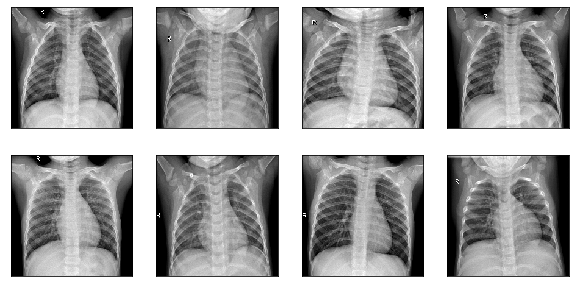

In [5]:
print('X-ray normal')
fig, axes = plt.subplots(ncols=4, nrows=2, sharex=False,
                         sharey=True, figsize=(10, 5))
index = 10
for i in range(2):
    for j in range(4):
        axes[i,j].imshow(normal_train[index])
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1
plt.show()

## Show Images (Pneumonia)

X-ray pneumonia


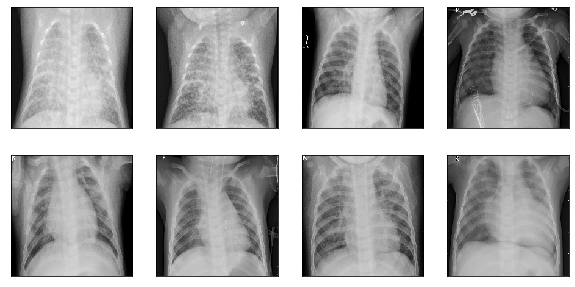

In [8]:
print('X-ray pneumonia')
fig, axes = plt.subplots(ncols=4, nrows=2, sharex=False,
                         sharey=True, figsize=(10, 5))
index = 100
for i in range(2):
    for j in range(4):
        axes[i,j].imshow(pneu_train[index])
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1
plt.show()

## Train and Test into one array (X data)

In [9]:
X_train = np.vstack((normal_train, pneu_train))
X_test = np.vstack((normal_test, pneu_test))

print('X_train.shape\t:', X_train.shape)
print('X_test.shape\t:', X_test.shape)

X_train.shape	: (5216, 200, 200, 3)
X_test.shape	: (624, 200, 200, 3)


## Labeling (y data)
#### 0 = normal, 1 = pneumonia

In [10]:
y_train = np.append([0] * normal_train.shape[0], [1] * pneu_train.shape[0])
y_test = np.append([0] * normal_test.shape[0], [1] * pneu_test.shape[0])

print('y_train.shape\t:', y_train.shape)
print('y_test.shape\t:', y_test.shape)

y_train.shape	: (5216,)
y_test.shape	: (624,)


## Shuffling Data

In [11]:
# into one array
train = np.array(list(zip(X_train, y_train)))
test = np.array(list(zip(X_test, y_test)))

# shuffle
np.random.shuffle(train)
np.random.shuffle(test)

# Separating X and Y train
X_train, y_train = zip(*train)
X_train = np.array(X_train)
y_train = np.array(y_train)

# Separating X and Y test
X_test, y_test = zip(*test)
X_test = np.array(X_test)
y_test = np.array(y_test)

## Data augmentation

In [12]:
datagen = ImageDataGenerator(
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)

datagen.fit(X_train)

## CNN 

In [13]:
X_train.shape

(5216, 200, 200, 3)

In [14]:
input1 = Input(shape=(200,200, 3))

### Convolution

In [15]:
cnn = Conv2D(16, (3, 3), activation='relu', 
             strides=(1, 1), padding='same')(input1)
cnn = Conv2D(32, (3, 3), activation='relu', 
             strides=(1, 1), padding='same')(cnn)
cnn = MaxPool2D((2, 2))(cnn)
cnn = Flatten()(cnn)

### Dropout, Dense, and Output layer

In [16]:
cnn = Dropout(0.5)(cnn)
cnn = Dense(100, activation='relu')(cnn)
cnn = Dropout(0.5)(cnn)
cnn = Dense(50, activation='relu')(cnn)
output1 = Dense(1, activation='sigmoid')(cnn)

In [17]:
model = Model(inputs=input1, outputs=output1)

In [18]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 200, 200, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 320000)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 320000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               3200

In [19]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', metrics=['acc'])

### Model Checkpoint

In [20]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_acc', 
                             mode='max', verbose=1, 
                             save_best_only=True, period=1)

## Training

In [21]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=32), 
                              epochs=30, shuffle=True, 
                              validation_data=(X_test, y_test), 
                              callbacks=[checkpoint])

Epoch 1/30
163/163 [==============================] - ETA: 5:53 - loss: 36.4440 - acc: 0.18 - ETA: 4:51 - loss: 542.6393 - acc: 0.453 - ETA: 4:28 - loss: 604.6304 - acc: 0.520 - ETA: 4:23 - loss: 606.8797 - acc: 0.523 - ETA: 4:12 - loss: 547.5215 - acc: 0.525 - ETA: 4:12 - loss: 481.1887 - acc: 0.552 - ETA: 4:14 - loss: 455.3336 - acc: 0.553 - ETA: 4:14 - loss: 419.3789 - acc: 0.570 - ETA: 4:14 - loss: 388.6167 - acc: 0.579 - ETA: 4:13 - loss: 354.2321 - acc: 0.596 - ETA: 4:14 - loss: 324.0870 - acc: 0.593 - ETA: 4:17 - loss: 298.5091 - acc: 0.572 - ETA: 4:18 - loss: 275.9476 - acc: 0.576 - ETA: 4:18 - loss: 256.4075 - acc: 0.580 - ETA: 4:17 - loss: 239.5170 - acc: 0.579 - ETA: 4:15 - loss: 224.8104 - acc: 0.580 - ETA: 4:13 - loss: 211.6886 - acc: 0.593 - ETA: 4:12 - loss: 200.0745 - acc: 0.597 - ETA: 4:10 - loss: 189.6161 - acc: 0.600 - ETA: 4:08 - loss: 180.2849 - acc: 0.598 - ETA: 4:07 - loss: 171.7582 - acc: 0.601 - ETA: 4:06 - loss: 163.9987 - acc: 0.605 - ETA: 4:04 - loss: 156.92

163/163 [==============================] - ETA: 4:24 - loss: 0.4811 - acc: 0.718 - ETA: 4:30 - loss: 0.4811 - acc: 0.796 - ETA: 4:32 - loss: 0.4955 - acc: 0.750 - ETA: 4:30 - loss: 0.4680 - acc: 0.757 - ETA: 4:29 - loss: 0.4476 - acc: 0.775 - ETA: 4:27 - loss: 0.4352 - acc: 0.781 - ETA: 4:26 - loss: 0.4228 - acc: 0.776 - ETA: 4:23 - loss: 0.4261 - acc: 0.769 - ETA: 4:20 - loss: 0.4459 - acc: 0.756 - ETA: 4:19 - loss: 0.4437 - acc: 0.756 - ETA: 4:17 - loss: 0.4415 - acc: 0.755 - ETA: 4:16 - loss: 0.4314 - acc: 0.760 - ETA: 4:15 - loss: 0.4193 - acc: 0.771 - ETA: 4:14 - loss: 0.4215 - acc: 0.767 - ETA: 4:14 - loss: 0.4281 - acc: 0.762 - ETA: 4:13 - loss: 0.4233 - acc: 0.767 - ETA: 4:11 - loss: 0.4294 - acc: 0.762 - ETA: 4:09 - loss: 0.4333 - acc: 0.762 - ETA: 4:07 - loss: 0.4286 - acc: 0.768 - ETA: 4:05 - loss: 0.4253 - acc: 0.771 - ETA: 4:04 - loss: 0.4193 - acc: 0.776 - ETA: 4:02 - loss: 0.4216 - acc: 0.778 - ETA: 4:01 - loss: 0.4193 - acc: 0.779 - ETA: 3:59 - loss: 0.4118 - acc: 0.786

163/163 [==============================] - ETA: 4:34 - loss: 0.2927 - acc: 0.875 - ETA: 4:27 - loss: 0.3433 - acc: 0.781 - ETA: 4:24 - loss: 0.3345 - acc: 0.791 - ETA: 4:23 - loss: 0.3971 - acc: 0.796 - ETA: 4:21 - loss: 0.3877 - acc: 0.787 - ETA: 4:20 - loss: 0.3777 - acc: 0.786 - ETA: 4:18 - loss: 0.4231 - acc: 0.776 - ETA: 4:17 - loss: 0.3969 - acc: 0.793 - ETA: 4:17 - loss: 0.4103 - acc: 0.791 - ETA: 4:17 - loss: 0.4286 - acc: 0.800 - ETA: 4:14 - loss: 0.4776 - acc: 0.806 - ETA: 4:12 - loss: 0.4749 - acc: 0.807 - ETA: 4:10 - loss: 0.4656 - acc: 0.810 - ETA: 4:08 - loss: 0.4582 - acc: 0.814 - ETA: 4:06 - loss: 0.4571 - acc: 0.812 - ETA: 4:04 - loss: 0.4500 - acc: 0.812 - ETA: 4:03 - loss: 0.4512 - acc: 0.808 - ETA: 4:02 - loss: 0.4437 - acc: 0.810 - ETA: 4:00 - loss: 0.4441 - acc: 0.810 - ETA: 3:59 - loss: 0.4342 - acc: 0.817 - ETA: 3:57 - loss: 0.4274 - acc: 0.815 - ETA: 3:55 - loss: 0.4310 - acc: 0.819 - ETA: 3:54 - loss: 0.4573 - acc: 0.817 - ETA: 3:52 - loss: 0.4545 - acc: 0.819

163/163 [==============================] - ETA: 4:12 - loss: 0.3489 - acc: 0.843 - ETA: 4:24 - loss: 0.3503 - acc: 0.875 - ETA: 4:27 - loss: 0.3562 - acc: 0.875 - ETA: 4:26 - loss: 0.3115 - acc: 0.882 - ETA: 4:25 - loss: 0.3150 - acc: 0.875 - ETA: 4:21 - loss: 0.3002 - acc: 0.880 - ETA: 4:18 - loss: 0.2942 - acc: 0.879 - ETA: 4:16 - loss: 0.3024 - acc: 0.871 - ETA: 4:14 - loss: 0.3189 - acc: 0.857 - ETA: 4:12 - loss: 0.3302 - acc: 0.853 - ETA: 4:11 - loss: 0.3227 - acc: 0.858 - ETA: 4:10 - loss: 0.3202 - acc: 0.859 - ETA: 4:09 - loss: 0.3159 - acc: 0.863 - ETA: 4:08 - loss: 0.3140 - acc: 0.863 - ETA: 4:06 - loss: 0.3209 - acc: 0.858 - ETA: 4:04 - loss: 0.3254 - acc: 0.859 - ETA: 4:02 - loss: 0.3336 - acc: 0.858 - ETA: 4:00 - loss: 0.3333 - acc: 0.857 - ETA: 3:59 - loss: 0.3359 - acc: 0.853 - ETA: 3:56 - loss: 0.3500 - acc: 0.850 - ETA: 3:55 - loss: 0.3455 - acc: 0.849 - ETA: 3:53 - loss: 0.3458 - acc: 0.848 - ETA: 3:52 - loss: 0.3470 - acc: 0.845 - ETA: 3:51 - loss: 0.3494 - acc: 0.842

163/163 [==============================] - ETA: 3:47 - loss: 0.2983 - acc: 0.906 - ETA: 4:05 - loss: 0.3371 - acc: 0.812 - ETA: 4:13 - loss: 0.4238 - acc: 0.833 - ETA: 4:23 - loss: 0.3939 - acc: 0.859 - ETA: 4:22 - loss: 0.3838 - acc: 0.837 - ETA: 4:23 - loss: 0.3729 - acc: 0.838 - ETA: 4:22 - loss: 0.3884 - acc: 0.834 - ETA: 4:21 - loss: 0.3815 - acc: 0.843 - ETA: 4:19 - loss: 0.3847 - acc: 0.833 - ETA: 4:18 - loss: 0.3702 - acc: 0.837 - ETA: 4:17 - loss: 0.3731 - acc: 0.835 - ETA: 4:16 - loss: 0.3777 - acc: 0.830 - ETA: 4:14 - loss: 0.3789 - acc: 0.826 - ETA: 4:12 - loss: 0.3710 - acc: 0.832 - ETA: 4:10 - loss: 0.3724 - acc: 0.831 - ETA: 4:08 - loss: 0.3783 - acc: 0.822 - ETA: 4:06 - loss: 0.3688 - acc: 0.825 - ETA: 4:04 - loss: 0.3694 - acc: 0.821 - ETA: 4:03 - loss: 0.3811 - acc: 0.817 - ETA: 4:02 - loss: 0.3847 - acc: 0.812 - ETA: 4:01 - loss: 0.3927 - acc: 0.806 - ETA: 4:00 - loss: 0.3889 - acc: 0.808 - ETA: 3:58 - loss: 0.3959 - acc: 0.803 - ETA: 3:57 - loss: 0.3924 - acc: 0.804

163/163 [==============================] - ETA: 4:14 - loss: 0.3581 - acc: 0.718 - ETA: 4:24 - loss: 0.3758 - acc: 0.781 - ETA: 4:31 - loss: 0.3498 - acc: 0.822 - ETA: 4:32 - loss: 0.3763 - acc: 0.812 - ETA: 4:29 - loss: 0.3590 - acc: 0.825 - ETA: 4:26 - loss: 0.3409 - acc: 0.828 - ETA: 4:23 - loss: 0.3258 - acc: 0.830 - ETA: 4:20 - loss: 0.3227 - acc: 0.839 - ETA: 4:18 - loss: 0.3424 - acc: 0.826 - ETA: 4:17 - loss: 0.3306 - acc: 0.837 - ETA: 4:15 - loss: 0.3267 - acc: 0.840 - ETA: 4:15 - loss: 0.3300 - acc: 0.841 - ETA: 4:13 - loss: 0.3436 - acc: 0.843 - ETA: 4:11 - loss: 0.3484 - acc: 0.839 - ETA: 4:09 - loss: 0.3496 - acc: 0.841 - ETA: 4:07 - loss: 0.3542 - acc: 0.841 - ETA: 4:05 - loss: 0.3481 - acc: 0.847 - ETA: 4:03 - loss: 0.3420 - acc: 0.849 - ETA: 4:01 - loss: 0.3380 - acc: 0.850 - ETA: 3:59 - loss: 0.3354 - acc: 0.848 - ETA: 3:58 - loss: 0.3324 - acc: 0.852 - ETA: 3:57 - loss: 0.3358 - acc: 0.848 - ETA: 3:55 - loss: 0.3502 - acc: 0.845 - ETA: 3:53 - loss: 0.3560 - acc: 0.842

163/163 [==============================] - ETA: 4:18 - loss: 0.3788 - acc: 0.843 - ETA: 4:24 - loss: 0.5545 - acc: 0.765 - ETA: 4:23 - loss: 0.4914 - acc: 0.781 - ETA: 4:24 - loss: 0.4102 - acc: 0.828 - ETA: 4:23 - loss: 0.4084 - acc: 0.831 - ETA: 4:22 - loss: 0.3952 - acc: 0.849 - ETA: 4:22 - loss: 0.3889 - acc: 0.843 - ETA: 4:21 - loss: 0.3678 - acc: 0.855 - ETA: 4:19 - loss: 0.3515 - acc: 0.857 - ETA: 4:17 - loss: 0.3530 - acc: 0.853 - ETA: 4:14 - loss: 0.3524 - acc: 0.843 - ETA: 4:12 - loss: 0.3524 - acc: 0.841 - ETA: 4:10 - loss: 0.3489 - acc: 0.843 - ETA: 4:08 - loss: 0.3455 - acc: 0.843 - ETA: 4:07 - loss: 0.3518 - acc: 0.839 - ETA: 4:06 - loss: 0.3405 - acc: 0.847 - ETA: 4:04 - loss: 0.3448 - acc: 0.840 - ETA: 4:03 - loss: 0.3420 - acc: 0.840 - ETA: 4:01 - loss: 0.3377 - acc: 0.840 - ETA: 3:59 - loss: 0.3393 - acc: 0.839 - ETA: 3:57 - loss: 0.3329 - acc: 0.842 - ETA: 3:55 - loss: 0.3348 - acc: 0.843 - ETA: 3:53 - loss: 0.3457 - acc: 0.838 - ETA: 3:52 - loss: 0.3534 - acc: 0.837

163/163 [==============================] - ETA: 3:30 - loss: 0.3215 - acc: 0.875 - ETA: 3:51 - loss: 0.3851 - acc: 0.812 - ETA: 4:00 - loss: 0.3348 - acc: 0.854 - ETA: 4:06 - loss: 0.3247 - acc: 0.859 - ETA: 4:08 - loss: 0.3549 - acc: 0.868 - ETA: 4:09 - loss: 0.3492 - acc: 0.869 - ETA: 4:10 - loss: 0.3393 - acc: 0.875 - ETA: 4:12 - loss: 0.3465 - acc: 0.871 - ETA: 4:12 - loss: 0.3503 - acc: 0.875 - ETA: 4:11 - loss: 0.3472 - acc: 0.868 - ETA: 4:09 - loss: 0.3433 - acc: 0.866 - ETA: 4:07 - loss: 0.3278 - acc: 0.872 - ETA: 4:05 - loss: 0.3259 - acc: 0.870 - ETA: 4:04 - loss: 0.3237 - acc: 0.868 - ETA: 4:03 - loss: 0.3281 - acc: 0.868 - ETA: 4:02 - loss: 0.3284 - acc: 0.863 - ETA: 4:01 - loss: 0.3214 - acc: 0.865 - ETA: 4:00 - loss: 0.3177 - acc: 0.864 - ETA: 3:58 - loss: 0.3186 - acc: 0.863 - ETA: 3:57 - loss: 0.3169 - acc: 0.862 - ETA: 3:55 - loss: 0.3164 - acc: 0.860 - ETA: 3:53 - loss: 0.3151 - acc: 0.862 - ETA: 3:52 - loss: 0.3151 - acc: 0.864 - ETA: 3:50 - loss: 0.3187 - acc: 0.863

163/163 [==============================] - ETA: 5:02 - loss: 0.4401 - acc: 0.781 - ETA: 5:03 - loss: 0.3801 - acc: 0.828 - ETA: 4:58 - loss: 0.3345 - acc: 0.843 - ETA: 4:53 - loss: 0.3487 - acc: 0.835 - ETA: 4:48 - loss: 0.3424 - acc: 0.831 - ETA: 4:42 - loss: 0.3833 - acc: 0.833 - ETA: 4:37 - loss: 0.4201 - acc: 0.825 - ETA: 4:33 - loss: 0.4061 - acc: 0.828 - ETA: 4:29 - loss: 0.3945 - acc: 0.833 - ETA: 4:26 - loss: 0.3777 - acc: 0.837 - ETA: 4:25 - loss: 0.3741 - acc: 0.835 - ETA: 4:23 - loss: 0.3683 - acc: 0.835 - ETA: 4:20 - loss: 0.3921 - acc: 0.836 - ETA: 4:18 - loss: 0.3913 - acc: 0.839 - ETA: 4:16 - loss: 0.3970 - acc: 0.837 - ETA: 4:13 - loss: 0.3848 - acc: 0.841 - ETA: 4:11 - loss: 0.3844 - acc: 0.840 - ETA: 4:08 - loss: 0.3849 - acc: 0.836 - ETA: 4:06 - loss: 0.3889 - acc: 0.837 - ETA: 4:04 - loss: 0.3878 - acc: 0.835 - ETA: 4:03 - loss: 0.3883 - acc: 0.836 - ETA: 4:01 - loss: 0.3881 - acc: 0.838 - ETA: 3:59 - loss: 0.3842 - acc: 0.839 - ETA: 3:57 - loss: 0.3833 - acc: 0.838

163/163 [==============================] - ETA: 4:29 - loss: 0.3299 - acc: 0.781 - ETA: 4:28 - loss: 0.3471 - acc: 0.828 - ETA: 4:30 - loss: 0.3632 - acc: 0.812 - ETA: 4:31 - loss: 0.3791 - acc: 0.796 - ETA: 4:30 - loss: 0.3588 - acc: 0.806 - ETA: 4:29 - loss: 0.3518 - acc: 0.833 - ETA: 4:27 - loss: 0.4027 - acc: 0.808 - ETA: 4:23 - loss: 0.3873 - acc: 0.816 - ETA: 4:21 - loss: 0.3768 - acc: 0.822 - ETA: 4:19 - loss: 0.3611 - acc: 0.828 - ETA: 4:16 - loss: 0.3540 - acc: 0.835 - ETA: 4:15 - loss: 0.3491 - acc: 0.838 - ETA: 4:14 - loss: 0.3451 - acc: 0.838 - ETA: 4:12 - loss: 0.3450 - acc: 0.839 - ETA: 4:11 - loss: 0.3437 - acc: 0.839 - ETA: 4:09 - loss: 0.3461 - acc: 0.837 - ETA: 4:07 - loss: 0.3444 - acc: 0.841 - ETA: 4:05 - loss: 0.3385 - acc: 0.843 - ETA: 4:03 - loss: 0.3307 - acc: 0.850 - ETA: 4:01 - loss: 0.3417 - acc: 0.846 - ETA: 3:59 - loss: 0.3350 - acc: 0.854 - ETA: 3:58 - loss: 0.3327 - acc: 0.853 - ETA: 3:56 - loss: 0.3251 - acc: 0.858 - ETA: 3:55 - loss: 0.3254 - acc: 0.854

163/163 [==============================] - ETA: 4:27 - loss: 0.4481 - acc: 0.843 - ETA: 4:28 - loss: 0.2974 - acc: 0.875 - ETA: 4:28 - loss: 0.2903 - acc: 0.864 - ETA: 4:28 - loss: 0.2716 - acc: 0.890 - ETA: 4:25 - loss: 0.2944 - acc: 0.881 - ETA: 4:24 - loss: 0.2789 - acc: 0.885 - ETA: 4:23 - loss: 0.2635 - acc: 0.888 - ETA: 4:22 - loss: 0.3141 - acc: 0.882 - ETA: 4:21 - loss: 0.3172 - acc: 0.875 - ETA: 4:19 - loss: 0.3243 - acc: 0.868 - ETA: 4:16 - loss: 0.3188 - acc: 0.869 - ETA: 4:14 - loss: 0.3079 - acc: 0.872 - ETA: 4:12 - loss: 0.3312 - acc: 0.853 - ETA: 4:10 - loss: 0.3201 - acc: 0.861 - ETA: 4:08 - loss: 0.3247 - acc: 0.858 - ETA: 4:06 - loss: 0.3249 - acc: 0.851 - ETA: 4:05 - loss: 0.3227 - acc: 0.854 - ETA: 4:03 - loss: 0.3296 - acc: 0.854 - ETA: 4:02 - loss: 0.3256 - acc: 0.858 - ETA: 4:00 - loss: 0.3234 - acc: 0.859 - ETA: 3:58 - loss: 0.3202 - acc: 0.858 - ETA: 3:57 - loss: 0.3228 - acc: 0.853 - ETA: 3:55 - loss: 0.3230 - acc: 0.851 - ETA: 3:53 - loss: 0.3174 - acc: 0.854

163/163 [==============================] - ETA: 4:46 - loss: 0.3577 - acc: 0.843 - ETA: 4:48 - loss: 0.3296 - acc: 0.843 - ETA: 4:42 - loss: 0.2763 - acc: 0.875 - ETA: 4:37 - loss: 0.2680 - acc: 0.882 - ETA: 4:33 - loss: 0.2678 - acc: 0.881 - ETA: 4:30 - loss: 0.2683 - acc: 0.885 - ETA: 4:26 - loss: 0.2819 - acc: 0.888 - ETA: 4:23 - loss: 0.2907 - acc: 0.875 - ETA: 4:21 - loss: 0.2797 - acc: 0.878 - ETA: 4:20 - loss: 0.2686 - acc: 0.878 - ETA: 4:19 - loss: 0.2624 - acc: 0.886 - ETA: 4:17 - loss: 0.2677 - acc: 0.882 - ETA: 4:15 - loss: 0.2679 - acc: 0.877 - ETA: 4:13 - loss: 0.2661 - acc: 0.875 - ETA: 4:11 - loss: 0.2801 - acc: 0.868 - ETA: 4:09 - loss: 0.2746 - acc: 0.873 - ETA: 4:07 - loss: 0.2731 - acc: 0.876 - ETA: 4:05 - loss: 0.2840 - acc: 0.876 - ETA: 4:03 - loss: 0.2847 - acc: 0.875 - ETA: 4:02 - loss: 0.2927 - acc: 0.868 - ETA: 4:00 - loss: 0.2958 - acc: 0.863 - ETA: 3:59 - loss: 0.3051 - acc: 0.862 - ETA: 3:58 - loss: 0.3067 - acc: 0.860 - ETA: 3:56 - loss: 0.3105 - acc: 0.858

163/163 [==============================] - ETA: 4:19 - loss: 0.1787 - acc: 0.937 - ETA: 4:20 - loss: 0.3206 - acc: 0.875 - ETA: 4:22 - loss: 0.3603 - acc: 0.843 - ETA: 4:22 - loss: 0.3376 - acc: 0.843 - ETA: 4:23 - loss: 0.3218 - acc: 0.850 - ETA: 4:23 - loss: 0.3210 - acc: 0.833 - ETA: 4:21 - loss: 0.3004 - acc: 0.852 - ETA: 4:18 - loss: 0.2997 - acc: 0.855 - ETA: 4:16 - loss: 0.2962 - acc: 0.857 - ETA: 4:14 - loss: 0.3066 - acc: 0.846 - ETA: 4:12 - loss: 0.3069 - acc: 0.843 - ETA: 4:10 - loss: 0.3076 - acc: 0.843 - ETA: 4:08 - loss: 0.3091 - acc: 0.853 - ETA: 4:06 - loss: 0.3158 - acc: 0.852 - ETA: 4:06 - loss: 0.3259 - acc: 0.850 - ETA: 4:04 - loss: 0.3196 - acc: 0.853 - ETA: 4:02 - loss: 0.3249 - acc: 0.854 - ETA: 4:00 - loss: 0.3337 - acc: 0.852 - ETA: 3:58 - loss: 0.3376 - acc: 0.845 - ETA: 3:56 - loss: 0.3353 - acc: 0.848 - ETA: 3:54 - loss: 0.3355 - acc: 0.846 - ETA: 3:52 - loss: 0.3325 - acc: 0.848 - ETA: 3:51 - loss: 0.3264 - acc: 0.850 - ETA: 3:49 - loss: 0.3291 - acc: 0.847

163/163 [==============================] - ETA: 4:32 - loss: 0.6414 - acc: 0.812 - ETA: 4:32 - loss: 0.4164 - acc: 0.859 - ETA: 4:34 - loss: 0.3987 - acc: 0.854 - ETA: 4:34 - loss: 0.3875 - acc: 0.843 - ETA: 4:31 - loss: 0.3828 - acc: 0.843 - ETA: 4:28 - loss: 0.4288 - acc: 0.838 - ETA: 4:24 - loss: 0.4244 - acc: 0.839 - ETA: 4:22 - loss: 0.4096 - acc: 0.839 - ETA: 4:19 - loss: 0.4063 - acc: 0.829 - ETA: 4:18 - loss: 0.4006 - acc: 0.821 - ETA: 4:17 - loss: 0.3798 - acc: 0.832 - ETA: 4:16 - loss: 0.3760 - acc: 0.833 - ETA: 4:15 - loss: 0.3754 - acc: 0.834 - ETA: 4:13 - loss: 0.3716 - acc: 0.834 - ETA: 4:11 - loss: 0.3638 - acc: 0.843 - ETA: 4:09 - loss: 0.3588 - acc: 0.845 - ETA: 4:07 - loss: 0.3603 - acc: 0.838 - ETA: 4:04 - loss: 0.3597 - acc: 0.838 - ETA: 4:03 - loss: 0.3581 - acc: 0.837 - ETA: 4:01 - loss: 0.3538 - acc: 0.840 - ETA: 3:59 - loss: 0.3538 - acc: 0.839 - ETA: 3:58 - loss: 0.3570 - acc: 0.833 - ETA: 3:56 - loss: 0.3531 - acc: 0.838 - ETA: 3:55 - loss: 0.3508 - acc: 0.837

163/163 [==============================] - ETA: 4:37 - loss: 0.2185 - acc: 0.843 - ETA: 4:35 - loss: 0.3506 - acc: 0.843 - ETA: 4:31 - loss: 0.3149 - acc: 0.843 - ETA: 4:30 - loss: 0.3016 - acc: 0.875 - ETA: 4:28 - loss: 0.2888 - acc: 0.881 - ETA: 4:28 - loss: 0.3461 - acc: 0.864 - ETA: 4:28 - loss: 0.3154 - acc: 0.875 - ETA: 4:26 - loss: 0.3171 - acc: 0.863 - ETA: 4:24 - loss: 0.3238 - acc: 0.864 - ETA: 4:21 - loss: 0.3111 - acc: 0.868 - ETA: 4:19 - loss: 0.3012 - acc: 0.869 - ETA: 4:19 - loss: 0.3041 - acc: 0.875 - ETA: 4:18 - loss: 0.2969 - acc: 0.877 - ETA: 4:16 - loss: 0.2900 - acc: 0.879 - ETA: 4:14 - loss: 0.2878 - acc: 0.883 - ETA: 4:13 - loss: 0.2902 - acc: 0.880 - ETA: 4:11 - loss: 0.2925 - acc: 0.876 - ETA: 4:10 - loss: 0.2902 - acc: 0.876 - ETA: 4:07 - loss: 0.2861 - acc: 0.879 - ETA: 4:05 - loss: 0.2824 - acc: 0.882 - ETA: 4:03 - loss: 0.2790 - acc: 0.883 - ETA: 4:01 - loss: 0.2768 - acc: 0.883 - ETA: 3:59 - loss: 0.2741 - acc: 0.883 - ETA: 3:57 - loss: 0.2737 - acc: 0.882

163/163 [==============================] - ETA: 4:40 - loss: 0.3457 - acc: 0.875 - ETA: 4:36 - loss: 0.2458 - acc: 0.906 - ETA: 4:31 - loss: 0.2751 - acc: 0.875 - ETA: 4:28 - loss: 0.2656 - acc: 0.867 - ETA: 4:26 - loss: 0.2770 - acc: 0.868 - ETA: 4:23 - loss: 0.2629 - acc: 0.880 - ETA: 4:22 - loss: 0.2765 - acc: 0.870 - ETA: 4:20 - loss: 0.2936 - acc: 0.863 - ETA: 4:20 - loss: 0.2864 - acc: 0.868 - ETA: 4:18 - loss: 0.2972 - acc: 0.862 - ETA: 4:16 - loss: 0.2943 - acc: 0.866 - ETA: 4:14 - loss: 0.3098 - acc: 0.859 - ETA: 4:12 - loss: 0.3015 - acc: 0.863 - ETA: 4:10 - loss: 0.2917 - acc: 0.870 - ETA: 4:08 - loss: 0.3006 - acc: 0.870 - ETA: 4:06 - loss: 0.2936 - acc: 0.877 - ETA: 4:04 - loss: 0.2972 - acc: 0.873 - ETA: 4:03 - loss: 0.2965 - acc: 0.871 - ETA: 4:02 - loss: 0.3003 - acc: 0.865 - ETA: 4:01 - loss: 0.3000 - acc: 0.865 - ETA: 3:59 - loss: 0.2992 - acc: 0.866 - ETA: 3:57 - loss: 0.2895 - acc: 0.870 - ETA: 3:55 - loss: 0.2888 - acc: 0.868 - ETA: 3:53 - loss: 0.2889 - acc: 0.865

163/163 [==============================] - ETA: 4:38 - loss: 0.2865 - acc: 0.906 - ETA: 4:37 - loss: 0.2168 - acc: 0.921 - ETA: 4:37 - loss: 0.2621 - acc: 0.885 - ETA: 4:35 - loss: 0.2429 - acc: 0.898 - ETA: 4:32 - loss: 0.2462 - acc: 0.875 - ETA: 4:28 - loss: 0.2369 - acc: 0.880 - ETA: 4:25 - loss: 0.2350 - acc: 0.879 - ETA: 4:24 - loss: 0.2382 - acc: 0.875 - ETA: 4:21 - loss: 0.2312 - acc: 0.878 - ETA: 4:19 - loss: 0.2452 - acc: 0.871 - ETA: 4:17 - loss: 0.2442 - acc: 0.872 - ETA: 4:17 - loss: 0.2575 - acc: 0.867 - ETA: 4:15 - loss: 0.2588 - acc: 0.865 - ETA: 4:13 - loss: 0.2564 - acc: 0.868 - ETA: 4:11 - loss: 0.2542 - acc: 0.870 - ETA: 4:09 - loss: 0.2502 - acc: 0.875 - ETA: 4:07 - loss: 0.2456 - acc: 0.878 - ETA: 4:06 - loss: 0.2488 - acc: 0.876 - ETA: 4:05 - loss: 0.2491 - acc: 0.875 - ETA: 4:03 - loss: 0.2489 - acc: 0.876 - ETA: 4:02 - loss: 0.2482 - acc: 0.879 - ETA: 4:01 - loss: 0.2568 - acc: 0.877 - ETA: 3:59 - loss: 0.2560 - acc: 0.879 - ETA: 3:58 - loss: 0.2572 - acc: 0.877

163/163 [==============================] - ETA: 4:30 - loss: 0.2682 - acc: 0.843 - ETA: 4:37 - loss: 0.2737 - acc: 0.859 - ETA: 4:40 - loss: 0.2401 - acc: 0.895 - ETA: 4:41 - loss: 0.2267 - acc: 0.890 - ETA: 4:44 - loss: 0.2413 - acc: 0.875 - ETA: 4:44 - loss: 0.2413 - acc: 0.875 - ETA: 4:42 - loss: 0.2261 - acc: 0.888 - ETA: 4:41 - loss: 0.2189 - acc: 0.890 - ETA: 4:39 - loss: 0.2695 - acc: 0.881 - ETA: 4:37 - loss: 0.2823 - acc: 0.871 - ETA: 4:35 - loss: 0.2912 - acc: 0.860 - ETA: 4:33 - loss: 0.2845 - acc: 0.867 - ETA: 4:32 - loss: 0.2910 - acc: 0.863 - ETA: 4:30 - loss: 0.2815 - acc: 0.866 - ETA: 4:28 - loss: 0.2838 - acc: 0.862 - ETA: 4:26 - loss: 0.2839 - acc: 0.861 - ETA: 4:23 - loss: 0.2842 - acc: 0.860 - ETA: 4:21 - loss: 0.2852 - acc: 0.861 - ETA: 4:19 - loss: 0.2871 - acc: 0.866 - ETA: 4:16 - loss: 0.2855 - acc: 0.868 - ETA: 4:15 - loss: 0.2845 - acc: 0.869 - ETA: 4:13 - loss: 0.2862 - acc: 0.866 - ETA: 4:12 - loss: 0.2814 - acc: 0.869 - ETA: 4:10 - loss: 0.2825 - acc: 0.871

163/163 [==============================] - ETA: 4:32 - loss: 0.2701 - acc: 0.875 - ETA: 4:37 - loss: 0.2155 - acc: 0.921 - ETA: 4:34 - loss: 0.1962 - acc: 0.927 - ETA: 4:32 - loss: 0.2258 - acc: 0.898 - ETA: 4:31 - loss: 0.2628 - acc: 0.881 - ETA: 4:31 - loss: 0.2724 - acc: 0.859 - ETA: 4:35 - loss: 0.2798 - acc: 0.866 - ETA: 4:36 - loss: 0.2821 - acc: 0.867 - ETA: 4:36 - loss: 0.2801 - acc: 0.861 - ETA: 4:35 - loss: 0.2984 - acc: 0.846 - ETA: 4:34 - loss: 0.2998 - acc: 0.846 - ETA: 4:33 - loss: 0.3135 - acc: 0.843 - ETA: 4:33 - loss: 0.3144 - acc: 0.843 - ETA: 4:32 - loss: 0.3134 - acc: 0.846 - ETA: 4:32 - loss: 0.3042 - acc: 0.854 - ETA: 4:30 - loss: 0.3011 - acc: 0.853 - ETA: 4:28 - loss: 0.3028 - acc: 0.851 - ETA: 4:25 - loss: 0.3243 - acc: 0.850 - ETA: 4:21 - loss: 0.3166 - acc: 0.852 - ETA: 4:18 - loss: 0.3114 - acc: 0.853 - ETA: 4:16 - loss: 0.3039 - acc: 0.857 - ETA: 4:13 - loss: 0.3078 - acc: 0.855 - ETA: 4:10 - loss: 0.3077 - acc: 0.851 - ETA: 4:08 - loss: 0.3029 - acc: 0.855

163/163 [==============================] - ETA: 4:35 - loss: 0.1678 - acc: 0.906 - ETA: 4:34 - loss: 0.1660 - acc: 0.937 - ETA: 4:29 - loss: 0.2443 - acc: 0.885 - ETA: 4:27 - loss: 0.2376 - acc: 0.890 - ETA: 4:25 - loss: 0.2526 - acc: 0.875 - ETA: 4:23 - loss: 0.2416 - acc: 0.875 - ETA: 4:21 - loss: 0.2634 - acc: 0.875 - ETA: 4:18 - loss: 0.2748 - acc: 0.855 - ETA: 4:17 - loss: 0.2674 - acc: 0.861 - ETA: 4:17 - loss: 0.2747 - acc: 0.856 - ETA: 4:15 - loss: 0.2759 - acc: 0.855 - ETA: 4:14 - loss: 0.2705 - acc: 0.859 - ETA: 4:13 - loss: 0.2631 - acc: 0.863 - ETA: 4:14 - loss: 0.2724 - acc: 0.859 - ETA: 4:14 - loss: 0.2842 - acc: 0.854 - ETA: 4:12 - loss: 0.2902 - acc: 0.853 - ETA: 4:11 - loss: 0.3037 - acc: 0.845 - ETA: 4:10 - loss: 0.3019 - acc: 0.847 - ETA: 4:09 - loss: 0.3102 - acc: 0.848 - ETA: 4:07 - loss: 0.3070 - acc: 0.850 - ETA: 4:06 - loss: 0.3025 - acc: 0.854 - ETA: 4:04 - loss: 0.3023 - acc: 0.855 - ETA: 4:02 - loss: 0.3068 - acc: 0.856 - ETA: 4:00 - loss: 0.3043 - acc: 0.858

163/163 [==============================] - ETA: 4:36 - loss: 0.2743 - acc: 0.875 - ETA: 4:33 - loss: 0.3448 - acc: 0.828 - ETA: 4:31 - loss: 0.3126 - acc: 0.843 - ETA: 4:29 - loss: 0.3206 - acc: 0.835 - ETA: 4:26 - loss: 0.3305 - acc: 0.837 - ETA: 4:26 - loss: 0.3391 - acc: 0.817 - ETA: 4:23 - loss: 0.3237 - acc: 0.830 - ETA: 4:23 - loss: 0.3118 - acc: 0.843 - ETA: 4:22 - loss: 0.3188 - acc: 0.840 - ETA: 4:20 - loss: 0.3129 - acc: 0.840 - ETA: 4:18 - loss: 0.2993 - acc: 0.852 - ETA: 4:17 - loss: 0.2889 - acc: 0.859 - ETA: 4:14 - loss: 0.2881 - acc: 0.860 - ETA: 4:12 - loss: 0.2871 - acc: 0.863 - ETA: 4:10 - loss: 0.2948 - acc: 0.862 - ETA: 4:09 - loss: 0.2981 - acc: 0.863 - ETA: 4:07 - loss: 0.3126 - acc: 0.856 - ETA: 4:06 - loss: 0.3132 - acc: 0.854 - ETA: 4:05 - loss: 0.3135 - acc: 0.856 - ETA: 4:03 - loss: 0.3077 - acc: 0.859 - ETA: 4:01 - loss: 0.3135 - acc: 0.860 - ETA: 3:59 - loss: 0.3093 - acc: 0.860 - ETA: 3:58 - loss: 0.3229 - acc: 0.853 - ETA: 3:56 - loss: 0.3251 - acc: 0.851

163/163 [==============================] - ETA: 4:33 - loss: 0.2819 - acc: 0.875 - ETA: 4:39 - loss: 0.2974 - acc: 0.875 - ETA: 4:38 - loss: 0.3211 - acc: 0.854 - ETA: 4:35 - loss: 0.3362 - acc: 0.843 - ETA: 4:33 - loss: 0.3903 - acc: 0.812 - ETA: 4:31 - loss: 0.3612 - acc: 0.822 - ETA: 4:32 - loss: 0.3684 - acc: 0.817 - ETA: 4:30 - loss: 0.3458 - acc: 0.835 - ETA: 4:28 - loss: 0.3428 - acc: 0.840 - ETA: 4:26 - loss: 0.3364 - acc: 0.840 - ETA: 4:25 - loss: 0.3248 - acc: 0.846 - ETA: 4:23 - loss: 0.3090 - acc: 0.854 - ETA: 4:24 - loss: 0.2976 - acc: 0.863 - ETA: 4:22 - loss: 0.2943 - acc: 0.863 - ETA: 4:19 - loss: 0.3027 - acc: 0.860 - ETA: 4:17 - loss: 0.3069 - acc: 0.853 - ETA: 4:15 - loss: 0.3123 - acc: 0.854 - ETA: 4:13 - loss: 0.3085 - acc: 0.854 - ETA: 4:11 - loss: 0.3080 - acc: 0.856 - ETA: 4:10 - loss: 0.3193 - acc: 0.857 - ETA: 4:09 - loss: 0.3090 - acc: 0.864 - ETA: 4:07 - loss: 0.3050 - acc: 0.866 - ETA: 4:05 - loss: 0.2999 - acc: 0.869 - ETA: 4:04 - loss: 0.3112 - acc: 0.865

163/163 [==============================] - ETA: 4:28 - loss: 0.2122 - acc: 0.906 - ETA: 4:30 - loss: 0.2123 - acc: 0.906 - ETA: 4:29 - loss: 0.2293 - acc: 0.895 - ETA: 4:27 - loss: 0.2618 - acc: 0.898 - ETA: 4:26 - loss: 0.2494 - acc: 0.893 - ETA: 4:25 - loss: 0.2911 - acc: 0.895 - ETA: 4:25 - loss: 0.2862 - acc: 0.901 - ETA: 4:23 - loss: 0.2956 - acc: 0.890 - ETA: 4:21 - loss: 0.3074 - acc: 0.885 - ETA: 4:18 - loss: 0.3110 - acc: 0.887 - ETA: 4:16 - loss: 0.2993 - acc: 0.892 - ETA: 4:15 - loss: 0.2893 - acc: 0.895 - ETA: 4:13 - loss: 0.2881 - acc: 0.894 - ETA: 4:11 - loss: 0.2833 - acc: 0.895 - ETA: 4:09 - loss: 0.2911 - acc: 0.891 - ETA: 4:08 - loss: 0.2886 - acc: 0.894 - ETA: 4:06 - loss: 0.2904 - acc: 0.889 - ETA: 4:06 - loss: 0.2906 - acc: 0.890 - ETA: 4:04 - loss: 0.2970 - acc: 0.886 - ETA: 4:04 - loss: 0.3068 - acc: 0.878 - ETA: 4:03 - loss: 0.3082 - acc: 0.873 - ETA: 4:02 - loss: 0.3075 - acc: 0.873 - ETA: 4:00 - loss: 0.3044 - acc: 0.875 - ETA: 3:58 - loss: 0.3027 - acc: 0.876

163/163 [==============================] - ETA: 4:59 - loss: 0.2283 - acc: 0.843 - ETA: 4:49 - loss: 0.1750 - acc: 0.906 - ETA: 4:45 - loss: 0.2094 - acc: 0.875 - ETA: 4:42 - loss: 0.2259 - acc: 0.867 - ETA: 4:39 - loss: 0.2469 - acc: 0.875 - ETA: 4:38 - loss: 0.2517 - acc: 0.875 - ETA: 4:37 - loss: 0.2673 - acc: 0.870 - ETA: 4:38 - loss: 0.2555 - acc: 0.875 - ETA: 4:38 - loss: 0.2490 - acc: 0.878 - ETA: 4:37 - loss: 0.2474 - acc: 0.878 - ETA: 4:34 - loss: 0.2466 - acc: 0.877 - ETA: 4:32 - loss: 0.2469 - acc: 0.882 - ETA: 4:30 - loss: 0.2861 - acc: 0.875 - ETA: 4:27 - loss: 0.2916 - acc: 0.870 - ETA: 4:24 - loss: 0.2826 - acc: 0.877 - ETA: 4:22 - loss: 0.2809 - acc: 0.871 - ETA: 4:20 - loss: 0.2928 - acc: 0.860 - ETA: 4:18 - loss: 0.2890 - acc: 0.862 - ETA: 4:17 - loss: 0.2896 - acc: 0.861 - ETA: 4:15 - loss: 0.2884 - acc: 0.862 - ETA: 4:13 - loss: 0.2840 - acc: 0.866 - ETA: 4:11 - loss: 0.2898 - acc: 0.860 - ETA: 4:09 - loss: 0.2883 - acc: 0.862 - ETA: 4:07 - loss: 0.2845 - acc: 0.863

163/163 [==============================] - ETA: 5:14 - loss: 0.2947 - acc: 0.875 - ETA: 4:56 - loss: 0.2882 - acc: 0.843 - ETA: 4:53 - loss: 0.2769 - acc: 0.854 - ETA: 4:55 - loss: 0.3384 - acc: 0.843 - ETA: 4:54 - loss: 0.3261 - acc: 0.843 - ETA: 4:55 - loss: 0.3076 - acc: 0.854 - ETA: 4:55 - loss: 0.3166 - acc: 0.852 - ETA: 4:53 - loss: 0.3152 - acc: 0.847 - ETA: 4:50 - loss: 0.3024 - acc: 0.857 - ETA: 4:47 - loss: 0.3047 - acc: 0.856 - ETA: 4:45 - loss: 0.3007 - acc: 0.863 - ETA: 4:41 - loss: 0.3113 - acc: 0.862 - ETA: 4:39 - loss: 0.3004 - acc: 0.867 - ETA: 4:36 - loss: 0.2993 - acc: 0.868 - ETA: 4:34 - loss: 0.3026 - acc: 0.864 - ETA: 4:30 - loss: 0.3015 - acc: 0.867 - ETA: 4:28 - loss: 0.3000 - acc: 0.865 - ETA: 4:25 - loss: 0.3005 - acc: 0.862 - ETA: 4:23 - loss: 0.3029 - acc: 0.863 - ETA: 4:20 - loss: 0.2992 - acc: 0.865 - ETA: 4:18 - loss: 0.2924 - acc: 0.869 - ETA: 4:15 - loss: 0.2900 - acc: 0.867 - ETA: 4:14 - loss: 0.2942 - acc: 0.866 - ETA: 4:12 - loss: 0.2907 - acc: 0.867

163/163 [==============================] - ETA: 4:37 - loss: 0.1391 - acc: 0.937 - ETA: 4:39 - loss: 0.2570 - acc: 0.906 - ETA: 4:41 - loss: 0.2454 - acc: 0.906 - ETA: 4:39 - loss: 0.2723 - acc: 0.890 - ETA: 4:33 - loss: 0.3221 - acc: 0.862 - ETA: 4:29 - loss: 0.3551 - acc: 0.843 - ETA: 4:26 - loss: 0.3491 - acc: 0.852 - ETA: 4:22 - loss: 0.3488 - acc: 0.851 - ETA: 4:20 - loss: 0.3260 - acc: 0.864 - ETA: 4:18 - loss: 0.3109 - acc: 0.871 - ETA: 4:17 - loss: 0.3064 - acc: 0.869 - ETA: 4:16 - loss: 0.3087 - acc: 0.862 - ETA: 4:14 - loss: 0.3021 - acc: 0.865 - ETA: 4:12 - loss: 0.3037 - acc: 0.863 - ETA: 4:10 - loss: 0.2961 - acc: 0.866 - ETA: 4:08 - loss: 0.2914 - acc: 0.869 - ETA: 4:06 - loss: 0.2860 - acc: 0.873 - ETA: 4:04 - loss: 0.2847 - acc: 0.875 - ETA: 4:02 - loss: 0.2823 - acc: 0.873 - ETA: 4:00 - loss: 0.2824 - acc: 0.875 - ETA: 3:59 - loss: 0.2854 - acc: 0.873 - ETA: 3:58 - loss: 0.2873 - acc: 0.872 - ETA: 3:56 - loss: 0.2897 - acc: 0.869 - ETA: 3:54 - loss: 0.2969 - acc: 0.863

163/163 [==============================] - ETA: 4:38 - loss: 0.2557 - acc: 0.843 - ETA: 5:00 - loss: 0.2704 - acc: 0.859 - ETA: 5:16 - loss: 0.2729 - acc: 0.875 - ETA: 5:08 - loss: 0.3132 - acc: 0.843 - ETA: 5:00 - loss: 0.3031 - acc: 0.856 - ETA: 4:55 - loss: 0.2988 - acc: 0.849 - ETA: 4:52 - loss: 0.2813 - acc: 0.866 - ETA: 4:50 - loss: 0.2721 - acc: 0.875 - ETA: 4:47 - loss: 0.2921 - acc: 0.868 - ETA: 4:44 - loss: 0.2780 - acc: 0.878 - ETA: 4:40 - loss: 0.2951 - acc: 0.877 - ETA: 4:36 - loss: 0.2820 - acc: 0.885 - ETA: 4:32 - loss: 0.2849 - acc: 0.884 - ETA: 4:29 - loss: 0.2762 - acc: 0.886 - ETA: 4:26 - loss: 0.2742 - acc: 0.885 - ETA: 4:25 - loss: 0.2768 - acc: 0.882 - ETA: 4:24 - loss: 0.2793 - acc: 0.882 - ETA: 4:22 - loss: 0.2739 - acc: 0.885 - ETA: 4:20 - loss: 0.2721 - acc: 0.886 - ETA: 4:18 - loss: 0.2799 - acc: 0.881 - ETA: 4:15 - loss: 0.2784 - acc: 0.882 - ETA: 4:13 - loss: 0.2816 - acc: 0.880 - ETA: 4:12 - loss: 0.2814 - acc: 0.877 - ETA: 4:10 - loss: 0.2830 - acc: 0.878

163/163 [==============================] - ETA: 4:43 - loss: 0.3263 - acc: 0.781 - ETA: 4:43 - loss: 0.3154 - acc: 0.781 - ETA: 4:44 - loss: 0.2791 - acc: 0.822 - ETA: 4:47 - loss: 0.2932 - acc: 0.828 - ETA: 4:46 - loss: 0.3062 - acc: 0.831 - ETA: 4:42 - loss: 0.2883 - acc: 0.843 - ETA: 4:39 - loss: 0.2740 - acc: 0.852 - ETA: 4:36 - loss: 0.2763 - acc: 0.843 - ETA: 4:33 - loss: 0.2666 - acc: 0.847 - ETA: 4:32 - loss: 0.2719 - acc: 0.840 - ETA: 4:31 - loss: 0.2607 - acc: 0.849 - ETA: 4:29 - loss: 0.2586 - acc: 0.851 - ETA: 4:29 - loss: 0.2638 - acc: 0.853 - ETA: 4:26 - loss: 0.2677 - acc: 0.850 - ETA: 4:23 - loss: 0.2700 - acc: 0.852 - ETA: 4:20 - loss: 0.2720 - acc: 0.851 - ETA: 4:17 - loss: 0.2720 - acc: 0.852 - ETA: 4:15 - loss: 0.2811 - acc: 0.845 - ETA: 4:13 - loss: 0.2838 - acc: 0.848 - ETA: 4:12 - loss: 0.2809 - acc: 0.851 - ETA: 4:11 - loss: 0.2791 - acc: 0.852 - ETA: 4:09 - loss: 0.2757 - acc: 0.856 - ETA: 4:08 - loss: 0.2774 - acc: 0.857 - ETA: 4:05 - loss: 0.2774 - acc: 0.860

163/163 [==============================] - ETA: 4:41 - loss: 0.1184 - acc: 0.937 - ETA: 4:36 - loss: 0.2321 - acc: 0.875 - ETA: 4:33 - loss: 0.2569 - acc: 0.875 - ETA: 4:29 - loss: 0.3027 - acc: 0.828 - ETA: 4:28 - loss: 0.3132 - acc: 0.825 - ETA: 4:27 - loss: 0.3138 - acc: 0.828 - ETA: 4:27 - loss: 0.2997 - acc: 0.843 - ETA: 4:29 - loss: 0.2834 - acc: 0.859 - ETA: 4:29 - loss: 0.2851 - acc: 0.854 - ETA: 4:30 - loss: 0.2963 - acc: 0.862 - ETA: 4:29 - loss: 0.2840 - acc: 0.872 - ETA: 4:26 - loss: 0.2922 - acc: 0.875 - ETA: 4:24 - loss: 0.2841 - acc: 0.875 - ETA: 4:22 - loss: 0.2904 - acc: 0.875 - ETA: 4:21 - loss: 0.2917 - acc: 0.868 - ETA: 4:20 - loss: 0.2963 - acc: 0.867 - ETA: 4:20 - loss: 0.2923 - acc: 0.869 - ETA: 4:21 - loss: 0.2893 - acc: 0.869 - ETA: 4:22 - loss: 0.2974 - acc: 0.865 - ETA: 4:21 - loss: 0.2899 - acc: 0.870 - ETA: 4:19 - loss: 0.2867 - acc: 0.869 - ETA: 4:18 - loss: 0.2864 - acc: 0.869 - ETA: 4:16 - loss: 0.2862 - acc: 0.866 - ETA: 4:15 - loss: 0.2861 - acc: 0.864

163/163 [==============================] - ETA: 5:52 - loss: 0.1703 - acc: 0.968 - ETA: 5:34 - loss: 0.1770 - acc: 0.953 - ETA: 5:29 - loss: 0.2187 - acc: 0.916 - ETA: 5:22 - loss: 0.2467 - acc: 0.890 - ETA: 5:14 - loss: 0.2556 - acc: 0.881 - ETA: 5:10 - loss: 0.2790 - acc: 0.875 - ETA: 5:09 - loss: 0.2778 - acc: 0.870 - ETA: 5:13 - loss: 0.2923 - acc: 0.867 - ETA: 5:08 - loss: 0.2746 - acc: 0.875 - ETA: 5:05 - loss: 0.2839 - acc: 0.871 - ETA: 5:02 - loss: 0.2854 - acc: 0.869 - ETA: 5:01 - loss: 0.2769 - acc: 0.872 - ETA: 4:59 - loss: 0.2756 - acc: 0.877 - ETA: 4:56 - loss: 0.2773 - acc: 0.877 - ETA: 4:53 - loss: 0.2765 - acc: 0.879 - ETA: 4:51 - loss: 0.2863 - acc: 0.873 - ETA: 4:50 - loss: 0.2951 - acc: 0.875 - ETA: 4:46 - loss: 0.2980 - acc: 0.871 - ETA: 4:43 - loss: 0.3011 - acc: 0.868 - ETA: 4:42 - loss: 0.2982 - acc: 0.870 - ETA: 4:40 - loss: 0.2971 - acc: 0.872 - ETA: 4:39 - loss: 0.3036 - acc: 0.869 - ETA: 4:37 - loss: 0.2975 - acc: 0.872 - ETA: 4:35 - loss: 0.2947 - acc: 0.873

## Plotting Loss value

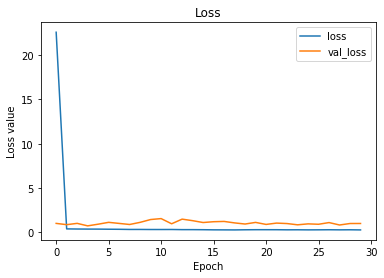

In [22]:
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

## Plotting Accuracy

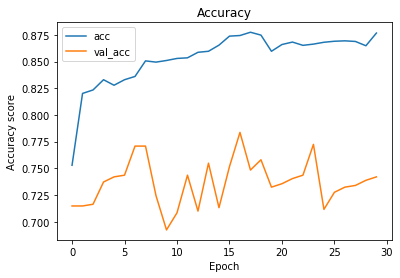

In [23]:
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy score')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.show()

## Load Model

In [24]:
model = load_model('./model.h5')
# model from epoch checkpoint

## Confusion Matrix

In [31]:
def confusionMatrix(image_to_predict, actual_labels):
    test_predictions = np.round(model.predict(image_to_predict))

    cm = confusion_matrix(actual_labels, test_predictions)

    plt.figure(figsize=(10,10))
    plt.title('Confusion matrix')
    sns.heatmap(cm, annot=True, fmt='d', 
                cmap=plt.cm.Blues, cbar=False, annot_kws={'size':14})
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

### For Training data

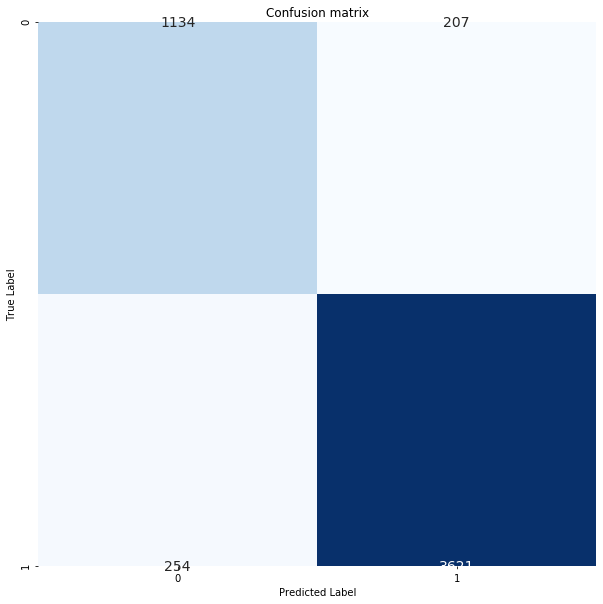

In [32]:
confusionMatrix(X_train, y_train)

### For testing data

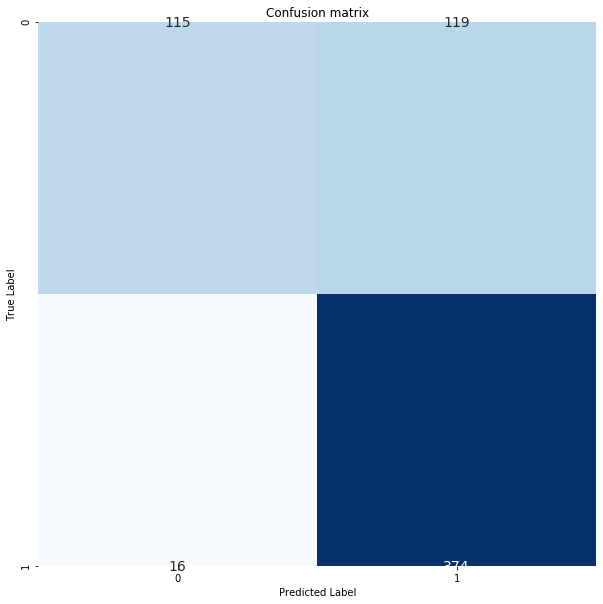

In [33]:
confusionMatrix(X_test, y_test)

## Testing using Validation Data

In [35]:
manual_test_normal = loadImages('./chest_xray/val/NORMAL/')
manual_test_pneu = loadImages('.//chest_xray/val/PNEUMONIA/')

100%|██████████| 8/8 [00:00<00:00, 67.98it/s]


In [36]:
manual_pred_normal = np.round(model.predict(manual_test_normal))
manual_pred_pneu = np.round(model.predict(manual_test_pneu))

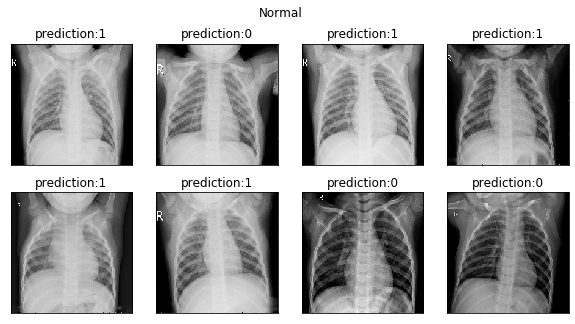

In [37]:

fig, axes = plt.subplots(ncols=4, nrows=2, sharex=False,
                         sharey=True, figsize=(10, 5))
plt.suptitle('Normal')
index = 0
for i in range(2):
    for j in range(4):
        axes[i,j].set_title('prediction:' + str(int(manual_pred_normal[index][0])))
        axes[i,j].imshow(manual_test_normal[index], cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1
plt.show()

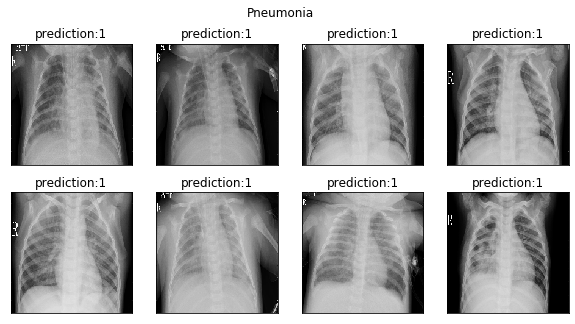

In [38]:
fig, axes = plt.subplots(ncols=4, nrows=2, sharex=False,
                         sharey=True, figsize=(10, 5))
plt.suptitle('Pneumonia')
index = 0
for i in range(2):
    for j in range(4):
        axes[i,j].set_title('prediction:' + str(int(manual_pred_pneu[index][0])))
        axes[i,j].imshow(manual_test_pneu[index], cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1
plt.show()